# Material Phase Identification Using CNNs (Ising Model)

References:

[1] J. Carrasquilla and R. G. Melko, “Machine learning phases of matter,” Nature Physics, vol. 13, no. May 2017, doi: 10.1038/NPHYS4035.

[2] https://rajeshrinet.github.io/blog/2014/ising-model/#Monte-Carlo-simulation-of-2D-Ising-model

[3] https://en.wikipedia.org/wiki/Ising_model


## Objective
The goal of this code is to view a set of observables  $x_{0}, ..., x_{n}$ from a sample datum $X = (x_{0}, ..., x_{n})$ and identify the phase of the system state described by $X$. 

In this case the, sample datum $X$ is taken from a Monte Carlo simulation of the Ising model of Hamiltonian:

$$ H^{Ising} = -J\sum_{<i,j>}s_{i}s_{j} - h \sum_{i}s_i $$

where:

 - $J$ is the (uniform) interaction between neighbor sites
 - $h$ is the external field, typically set to 0 for simplicity
 - $<i,j>$ specifies that the summation is applied only to the pair $i,j$ if they are neighbors
 - $s_{i}$ is the spin $[-1,1]$
 
 Note the state space is of cardinality $2^N$ for $N$ sites. 
 
## Method

The method is as follows: 

1. Use the Monte Carlo methods to generate a range of states $X$ both above and below the transition temperature $T_{c}$, as determined by the Hamiltonian parameters $J$ and $h$. The states are represented by the Ising lattice. 

2. Split the generated states into test and training sets, with the target variable being the temperature $T$, order parameter, or other desired thermodynamic variable. 

3. Using a CNN applied over sublattices of the Ising lattice (analogous to scanning over an image), perform training. 

4. Apply the trained model to the test set to predict the thermodynamic variables of interest. 


Note that $T_c$ has an analytic expression via Onsager's exact solution of the Ising model for the isotropic case [3]:

$$ T_{c} = \frac{2J}{k ln(1+\sqrt{2})} $$


## CNN Architecture 

Quoting from the Supplementary Material of [1]:

_The exact architecture of the convolutional neural network (CNN) 4, schematically described in Figure 4 in the main text, is as follows. The input layer is a two-dimensional Ising spin configura- tion with N = 16 × 16 × 2 spins, where σi = ±1. The first hidden layer convolves 64 2 × 2 filters on each of the two sublattices of the model with a unit stride, no padding, with periodic boundary conditions, followed by rectified linear unit (ReLu). The final hidden layer is a fully-connected layer with 64 ReLu units, while the output is a softmax layer with two outputs (correponding to T = 0 and T = ∞ states). To prevent overfitting, we apply a dropout regularization in the fully-connected layer 5. Our model has been implemented using TensorFlow._


Additionally, they use the following parameters in their model training:

 - Adam optimizer
 - Cross-entropy cost function 
 - L2 regularization


## Imports 

In [1]:
import seaborn as sns
import ipdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import ReLU
from keras.layers import Reshape
from keras.layers import Flatten

from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

import tensorflow as tf



from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split


Using TensorFlow backend.
/Users/stuarttruax/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/stuarttruax/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/stuarttruax/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/stuarttruax/opt/ana

## Parameters

In [2]:
N_lattice = 64

## Load Monte Carlo Simulation Outputs

In [3]:
try: 
    data = pd.read_pickle("states_%d_256.pkl"%(N_lattice))
except:
    print("!!! Could not read dataframe from file !!!!!!")

In [4]:
# form dataset for training and inference
X = list(data["lattice_state"])
Y = list(data["above_T_c"])

#add nominal 3rd dimension to Ising lattices
for i,x in enumerate(X):
    X[i] = np.reshape(X[i] ,(N_lattice,N_lattice,1))

#convert target to categorical variable
Y_binary = to_categorical(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y_binary, test_size=0.5)

In [5]:
#make the encapsulating lists np arrays
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)




## Model Training

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 63, 63, 64)        320       
_________________________________________________________________
flatten_2 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 254016)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16257088  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 16,257,538
Trainable params: 16,257,538
Non-trainable params: 0
_________________________________________________________________
None


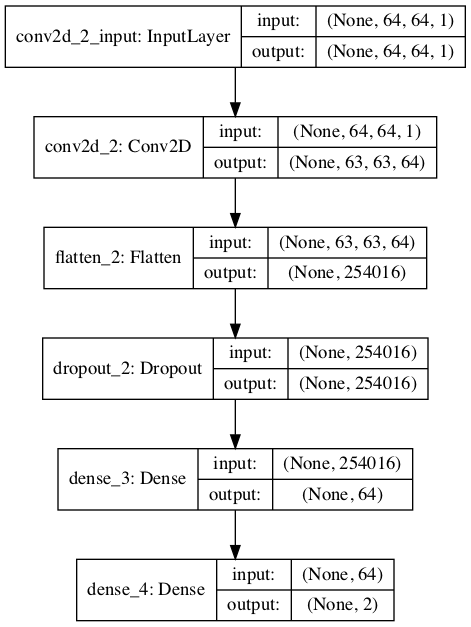

In [11]:
#construct the architecture

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size=(2, 2), strides=(1,1), activation='relu', input_shape=(N_lattice, N_lattice,1)))
model.add(Flatten())
model.add(Dropout(0.5)) 
model.add(Dense(64, activation='relu')) # i.e. the fully connected layer
model.add(Dense(2, activation='softmax')) # T=0 and T=inf states

print(model.summary())
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

In [15]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 75

history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 102 samples, validate on 26 samples
Epoch 1/75
102/102 [==============================] - 1s 9ms/step - loss: 0.9635 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


/Users/stuarttruax/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/75
102/102 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/75
102/102 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/75
102/102 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/75
102/102 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0

Epoch 57/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 58/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 59/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 60/75
102/102 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 61/75
102/102 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 62/75
102/102 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 63/75
102/102 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accura

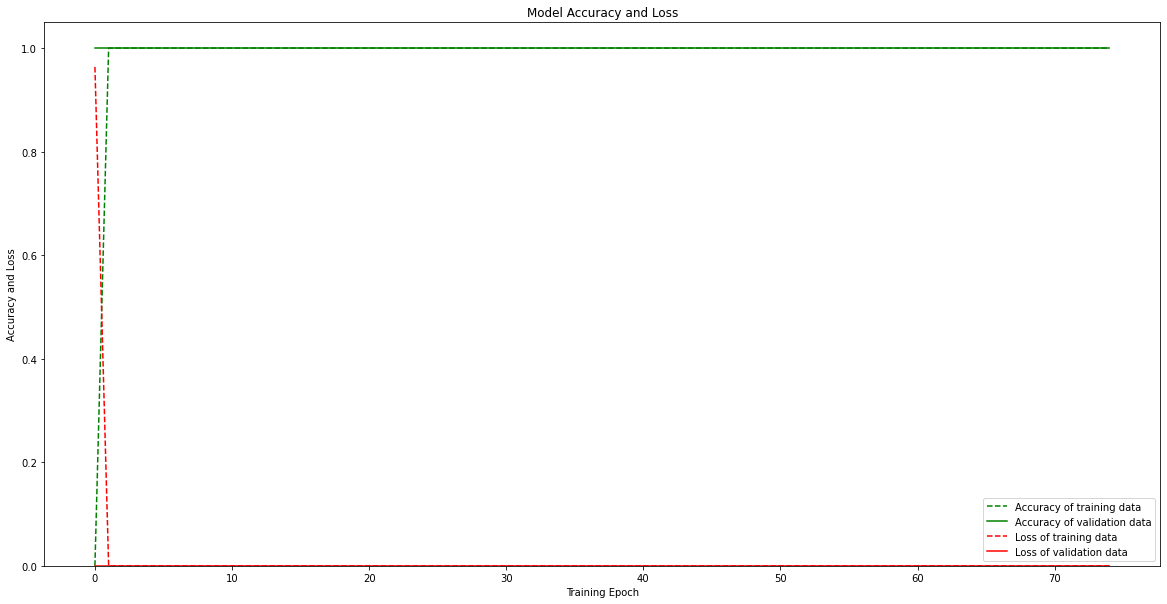

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

## Model Inference

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

128/128 [==============================] - 0s 865us/step

Accuracy on test data: 1.00

Loss on test data: 0.00
